In [2]:
import json
import geopandas as gpd
from geopandas import GeoDataFrame
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import contextily as ctx
#import folium
#from folium.plugins import Search
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cartopy.mpl.ticker as cticker
import cartopy.feature as cfeature
#from skimage.transform import resize
from matplotlib_scalebar.scalebar import ScaleBar
from shapely.geometry import Polygon
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.font_manager as fm
from PIL import Image
from matplotlib.lines import Line2D
import math
import numpy as np
import os
from datetime import datetime

## Checking Shapefiles

In [4]:
# Load the configuration from the JSON file
with open('cartography_config.json', 'r', encoding='utf-8') as f:
    config = json.load(f)

# Change these inputs in config.json
shapefile_path = config['shapefiles']['path1']

# Load the shapefiles
shapefile = gpd.read_file(shapefile_path)

# See the contents of the shapefile
shapefile.head()

,id,area,geometry
0,13.0,13.275,"POLYGON ((753218.363 4229472.057, 753155.358 4..."
1,9922.0,9922.200,"POLYGON ((750945.901 4213977.464, 750868.848 4..."
2,3.0,3.124,"POLYGON ((750987.099 4214146.137, 751024.785 4..."
3,1.0,1.371,"POLYGON ((751166.546 4213977.838, 751168.909 4..."
4,1.0,0.745,"POLYGON ((750694.010 4213764.015, 750688.103 4..."


## 3 shapefiles

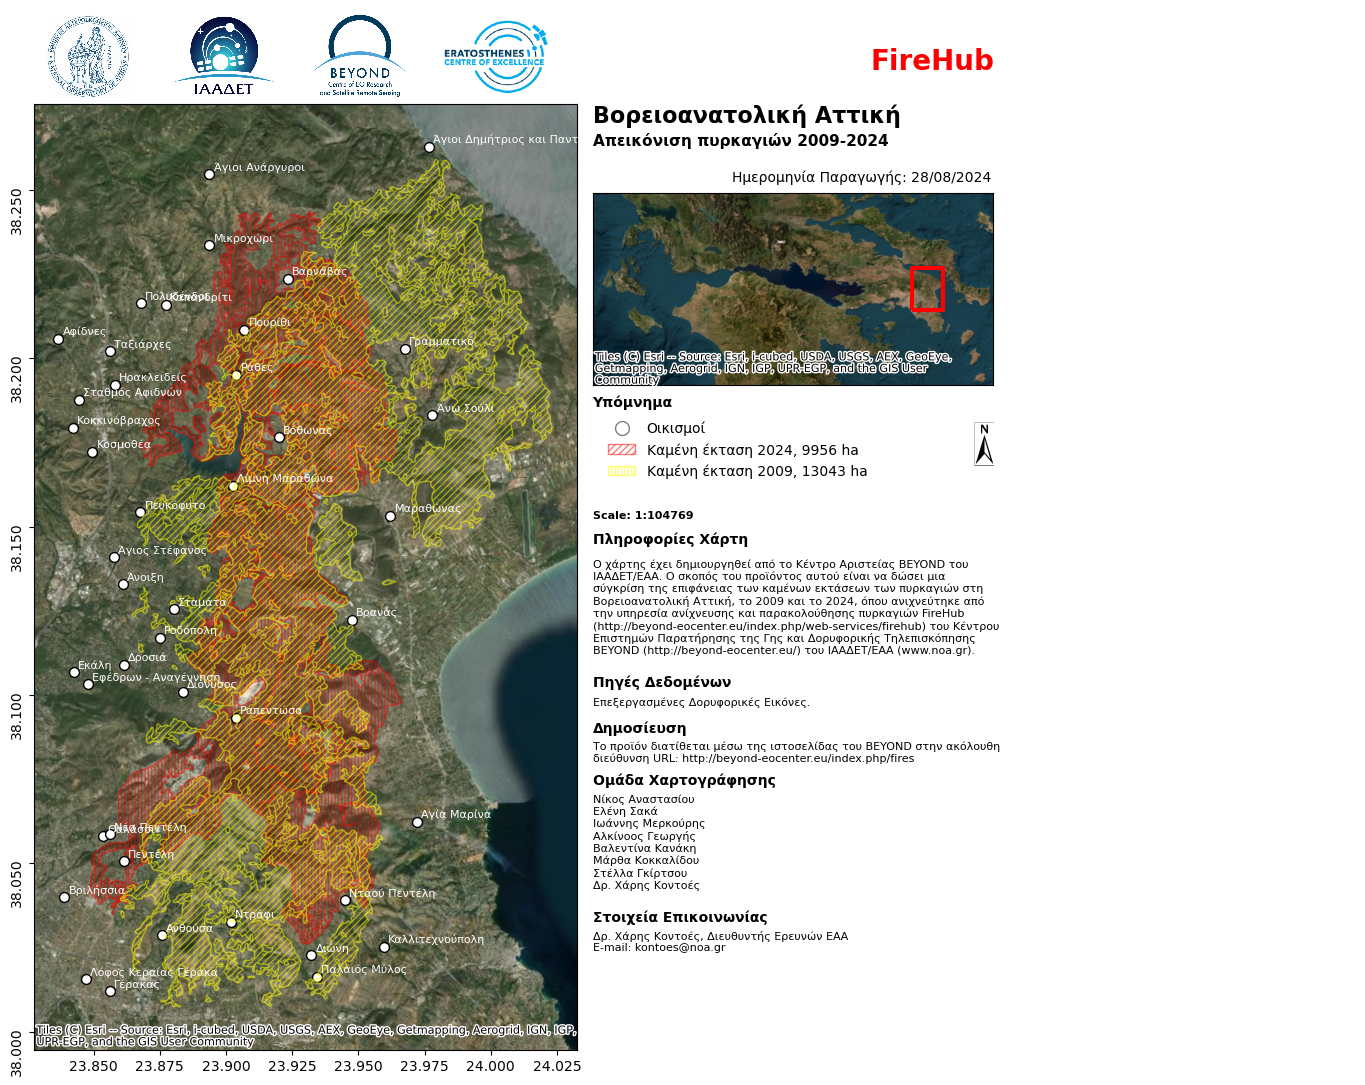

In [39]:
# Load the configuration from the JSON file
with open('comparison_config.json', 'r', encoding='utf-8') as f:
    config = json.load(f)

# Load the shapefiles
shapefile1 = gpd.read_file(config['shapefiles']['path1'])
shapefile2 = gpd.read_file(config['shapefiles']['path2'])
shapefile3 = gpd.read_file(config['shapefiles']['path3'])

# Set and reproject CRS
shapefile1.crs = config['shapefiles']['epsg1']
shapefile2.crs = config['shapefiles']['epsg2']
shapefile3.crs = config['shapefiles']['epsg3']
shapefile1 = shapefile1.to_crs(epsg=4326)  # Reproject in WGS84
shapefile2 = shapefile2.to_crs(epsg=4326)  # Reproject in WGS84
shapefile3 = shapefile3.to_crs(epsg=4326)  # Reproject in WGS84

# Get the bounding box of the larger shapefile
x_min, y_min, x_max, y_max = shapefile1.total_bounds
width = x_max - x_min
height = y_max - y_min
avg_latitude = (y_min + y_max) / 2

# Optionally adjust the bounding box size
expansion_factor = config['map']['expansion_factor']  #adjust this for zoom
x_min -= width * expansion_factor
x_max += width * expansion_factor
y_min -= height * expansion_factor
y_max += height * expansion_factor

# Create a polygon for the bounding box
bbox_polygon = Polygon([(x_min, y_min), (x_max, y_min), (x_max, y_max), (x_min, y_max), (x_min, y_min)])
bbox_gdf = gpd.GeoDataFrame({'geometry': [bbox_polygon]}, crs=shapefile3.crs)

# Filter shapefile2 to only include points within the bounding box of shapefile1
bounded_shapefile1 = shapefile1[shapefile1.geometry.within(bbox_polygon)]
bounded_shapefile2 = shapefile2[shapefile2.geometry.within(bbox_polygon)]

# Create the plot
fig, ax = plt.subplots(figsize=(10, 10))
dpi = fig.dpi  # Get the DPI setting
figure_width_in_inches = fig.get_size_inches()[0]  # Get the width of the figure in inches
map_width_pixels = figure_width_in_inches * dpi  # Calculate the width in pixels
bounded_shapefile1.plot(ax=ax, edgecolor='red', facecolor='none', alpha=0.5, hatch='|||||', legend=True)
bounded_shapefile2.plot(ax=ax, edgecolor='black', facecolor='white', markersize=50, alpha=1, marker='o', legend=True)
shapefile3.plot(ax=ax, edgecolor='yellow', facecolor='none', alpha=0.5, hatch='/////', legend=True)

# Annotate the names of the areas
for idx, row in bounded_shapefile2.iterrows():
    plt.annotate(text=row['name'], xy=(row.geometry.centroid.x, row.geometry.centroid.y), xytext=(3, 3), textcoords='offset points', fontsize=8, color='white') # change name according to column name of the settlements

# Add the satellite basemap using contextily
ctx.add_basemap(ax, crs=shapefile3.crs.to_string(), source=ctx.providers.Esri.WorldImagery)
plt.tight_layout()

# Set the coordinates to be displayed vertically
ax.tick_params(axis='x', rotation=0)
ax.tick_params(axis='y', rotation=90)

# Set the format for the coordinates
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.3f}'))
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.3f}'))

# Calculate latitude and longitude ranges
lat_mid = (y_max + y_min) / 2  # Use the midpoint latitude for accuracy
cos_lat = np.cos(np.radians(lat_mid))  # Cosine of the latitude for longitude adjustment

# Improved horizontal and vertical scales in meters
scale_x = (x_max - x_min) * 111000 * cos_lat  # Horizontal scale adjusted for latitude
scale_y = (y_max - y_min) * 111000  # Vertical scale remains the same

# Determine the maximum scale for consistency
scale = max(scale_x, scale_y)

# Calculate the scale ratio for the map (e.g., 1:100000)
# Assuming your map is being displayed at a specific width in pixels, you can use that to get the scale ratio
real_world_width_meters = scale_x  # The real-world width represented by the map

scale_ratio = real_world_width_meters / width  # Meters per pixel

# Determine the appropriate scale text
scale_text = f"Scale: 1:{int(scale_ratio)}"

######NEW

# Create the inset map showing the area of interest (AOI)
# shapefile1 = shapefile1.to_crs(epsg=4326)
# x_min, y_min, x_max, y_max = shapefile1.total_bounds
# width = x_max - x_min
# height = y_max - y_min
expansion_factor = config['map']['expansion_factor2']  #adjust this value as needed to control the size of the AOI
x_min_ = x_min + (width * expansion_factor)
x_max_ = x_max - (width * config['map']['ysize'] * expansion_factor)
y_min_ = y_min + (height * expansion_factor)
y_max_ = y_max - (height * expansion_factor)

aoi_polygon = Polygon([(x_min-0.1, y_min-0.1), (x_max+0.1, y_min-0.1), (x_max+0.1, y_max+0.1), (x_min-0.1, y_max+0.1)]) #adjust size of red square
aoi_polygon_ = Polygon([(x_min_, y_min_), (x_max_, y_min_), (x_max_, y_max_), (x_min_, y_max_)])
aoi_gdf = gpd.GeoDataFrame(geometry=[aoi_polygon], crs=shapefile1.crs)
aoi_gdf_ = gpd.GeoDataFrame(geometry=[aoi_polygon_], crs=shapefile1.crs)

# Adjust the coordinates for the inset to be placed under the title
inset_ax = fig.add_axes([config['map']['x'], config['map']['y'], config['map']['width'], config['map']['height']])  #adjusted coordinates of smaller map
aoi_gdf_.plot(ax=inset_ax, edgecolor='red', facecolor='none', alpha=0, legend=True)
aoi_gdf.plot(ax=inset_ax, edgecolor='red', facecolor='none', alpha=1, linewidth=3, legend=True)
ctx.add_basemap(inset_ax, crs=shapefile1.crs.to_string(), source=ctx.providers.Esri.WorldImagery)
inset_ax.set_xticks([])
inset_ax.set_yticks([])
inset_ax.set_xlabel('')
inset_ax.set_ylabel('')

##########

# Add logo
#logo = plt.imread('C:\\Users\\User\\Documents\\Projects_2022\\FireHub_FireMapping_Summer\\FB TIMELINE 1200X675.jpg')
#ax.imshow(logo, extent=(0.8, 1, 0.8, 1), transform=ax.transAxes)
#small_logo = resize(logo, (200, 200)) # resize logo to 200x200 pixels

#Add title
plt.text(config['firehub']['x'], config['firehub']['y'], config['firehub']['name'], transform=ax.transAxes, rotation=0, va='top', fontweight='bold', fontsize=20, color='red') #adjust for position of FireHub

xtext = config['text_position']['x'] #adjust for position of some text on the x axis
ytext = config['text_position']['y'] #adjust for position of some text on the y axis

# Add legend
plt.text(xtext, ytext + config['ypomnima']['y'], config['ypomnima']['name'], transform=ax.transAxes, rotation=0, ha='left', va='baseline', fontweight='bold', fontsize=10) #adjust for position of "Υπόμνημα"
bbox_gdf.plot(ax=ax, edgecolor='red', facecolor='red', alpha=0, legend=True) 
plt.plot(bounded_shapefile1[config['ypomnima']['id_name1']], label=config['ypomnima']['label1']) #adjust id according to id of the burned area
plt.plot(bounded_shapefile2[config['ypomnima']['id_name2']], label=config['ypomnima']['label2']) #adust id according to id of the settlements
plt.plot(shapefile3[config['ypomnima']['id_name3']], label=config['ypomnima']['label3']) #adjust id according to id of the burned area
fire = mpatches.Patch(edgecolor='red', facecolor='none', alpha=0.5, hatch='/////', label=config['ypomnima']['label1'])
settlement = Line2D([0], [0], marker='o', color='w', label=config['ypomnima']['label2'], markerfacecolor='white', markeredgecolor='black', markersize=10, alpha=0.5)
previous_fire = mpatches.Patch(edgecolor='yellow', facecolor='none', alpha=0.5, hatch='|||||', label=config['ypomnima']['label3'])
legend = plt.legend(loc='right', title_fontproperties=fm.FontProperties(weight='bold'), bbox_to_anchor=(config['ypomnima']['xlabel'], config['ypomnima']['ylabel']), borderaxespad=0, frameon=False, handles=[settlement, fire, previous_fire]) #adjust for position of ypomnima values
# plt.setp(legend.get_title(), position=(-33.5, 0))  # Adjust this to move the title

# Create a location map showing the full extent of the data
#https://mohammadimranhasan.com/geospatial-data-mapping-with-python/
#a=inset_axes(shapefile1, width="30%", height='30%',loc='lower right')
#shapefile1.plot(figsize=(20,20), cmap='PuOr',ax=a)
#a.text(x=88.6, y=22.25, s='Study Area', fontsize=10)
#a.plot([88.9, 90, 90, 88.9, 88.9],[21.5, 21.5, 23, 23,21.5], lw=2)

# Get the current date
today = datetime.today().date()
today = today.strftime("%d/%m/%Y")

# Add standardised text on the side of the map
#ax.set_title(place, rotation=0, position=(1.029, 0), ha='left', va='baseline', fontweight='bold')
#adjust everything for position of text
plt.text(xtext, config['place']['y'], config['place']['name'], transform=ax.transAxes, rotation=0, ha='left', va='baseline', fontweight='bold', fontsize=16)
plt.text(xtext, config['subtitle']['y'], config['subtitle']['name'], transform=ax.transAxes, fontsize=11, va='top', fontweight='bold')
plt.text(config['production_date']['x'], config['production_date']['y'], config['production_date']['name'] + today, transform=ax.transAxes, fontsize=10, va='top')
plt.text(xtext, ytext + 0.335, scale_text, transform=ax.transAxes, fontsize=8, va='center', fontweight='bold')
plt.text(xtext, ytext + config['map_information']['y_name'], config['map_information']['name'], transform=ax.transAxes, fontsize=10, va='center', fontweight='bold')
plt.text(xtext, ytext + config['map_information']['y_text'], config['map_information']['text'].replace('{place}', config['place']['name']), transform=ax.transAxes, fontsize=8, va='center')
plt.text(xtext, ytext + config['sources']['y_name'], config['sources']['name'], transform=ax.transAxes, fontsize=10, va='center', fontweight='bold')
plt.text(xtext, ytext + config['sources']['y_text'], config['sources']['text'], transform=ax.transAxes, fontsize=8, va='center')
plt.text(xtext, ytext + config['publication']['y_name'], config['publication']['name'], transform=ax.transAxes, fontsize=10, va='center', fontweight='bold')
plt.text(xtext, ytext + config['publication']['y_text'], config['publication']['text'], transform=ax.transAxes, fontsize=8, va='center')
plt.text(xtext, ytext + config['team']['y_name'], config['team']['name'], transform=ax.transAxes, fontsize=10, va='center', fontweight='bold')
plt.text(xtext, ytext + config['team']['y_text'], config['team']['text'], transform=ax.transAxes, fontsize=8, va='center')
plt.text(xtext, ytext + config['contact_details']['y_name'], config['contact_details']['name'], transform=ax.transAxes, fontsize=10, va='center', fontweight='bold')
plt.text(xtext, ytext + config['contact_details']['y_text'], config['contact_details']['text'], transform=ax.transAxes, fontsize=8, va='center')

# Add north
logo_image = plt.imread(config['logos']['north'])
logo_plot = OffsetImage(logo_image, zoom=0.7)  #adjust zoom to control logo size
ab = AnnotationBbox(logo_plot, (config['logos']['x_north'], ytext + config['logos']['y_north']), xycoords='axes fraction', frameon=False) #adjust position of north arrow
ax.add_artist(ab)

# x, y, arrow_length = 1.9, 0.6, 0.1
# ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
#             arrowprops=dict(facecolor='black', width=5, headwidth=15),
#             ha='center', va='top', fontsize=20,
#             xycoords=ax.transAxes)

# logo_path = 'logos\BEYOND_LOGO.png'  # Replace with the actual path to your logo image
# logo_image = plt.imread(logo_path)
# logo_plot = OffsetImage(logo_image, zoom=0.03)  # Adjust zoom to control logo size
# ab = AnnotationBbox(logo_plot, (x_max-0.030, y_max - height+0.001), frameon=True)
# ax.add_artist(ab)

# logo_path = 'logos\IAADET.jpeg'  # Replace with the actual path to your logo image
# logo_image = plt.imread(logo_path)
# logo_plot = OffsetImage(logo_image, zoom=0.09)  # Adjust zoom to control logo size
# ab = AnnotationBbox(logo_plot, (x_max-0.015, y_max - height+0.001), frameon=True)
# ax.add_artist(ab)

# logo_path = 'logos\AsteroskopoioLogoOuranidon.png'  # Replace with the actual path to your logo image
# logo_image = plt.imread(logo_path)
# logo_plot = OffsetImage(logo_image, zoom=0.1)  # Adjust zoom to control logo size
# ab = AnnotationBbox(logo_plot, (x_max-0.002, y_max - height+0.001), frameon=True)
# ax.add_artist(ab)

#######NEWNEW

# Add logos to the plot
logo_paths = [
    (config['logos']['first'], 0.185),
    (config['logos']['second'], 0.08),
    (config['logos']['third'], 0.123),
    (config['logos']['fourth'], 0.5)
]

# Adjusted coordinates for logos placed side by side
for i, (logo_path, zoom) in enumerate(logo_paths):
    logo_image = plt.imread(logo_path)
    logo_plot = OffsetImage(logo_image, zoom=zoom)
    ab = AnnotationBbox(logo_plot, (config['logos']['x'] + i*0.25, config['logos']['y']), xycoords='axes fraction', frameon=False) #adjust position of logos
    ax.add_artist(ab)

#########

# Save the figure
burned_map = config['images']['burned_map']
cropped_burned_map = config['images']['cropped_burned_map']
plt.savefig(burned_map, dpi=config['images']['dpi'], bbox_inches='tight')

# Show the plot
plt.show()

# Close the figure to release memory
plt.close(fig)

# Load the image
image = Image.open(burned_map)

# Get the dimensions of the original image
width, height = image.size

# Define the crop area
left = 0       # Keep the left side as is
upper = 0      # Keep the top side as is
right = width - config['images']['crop_factor']  # Crop 100 pixels from the right
lower = height  # Keep the bottom side as is

# Crop the image
cropped_image = image.crop((left, upper, right, lower))

# Save the cropped image
cropped_image.save(cropped_burned_map)

# Delete the original image
os.remove(burned_map)

# Optionally, show the cropped image
cropped_image.show()

## Normal

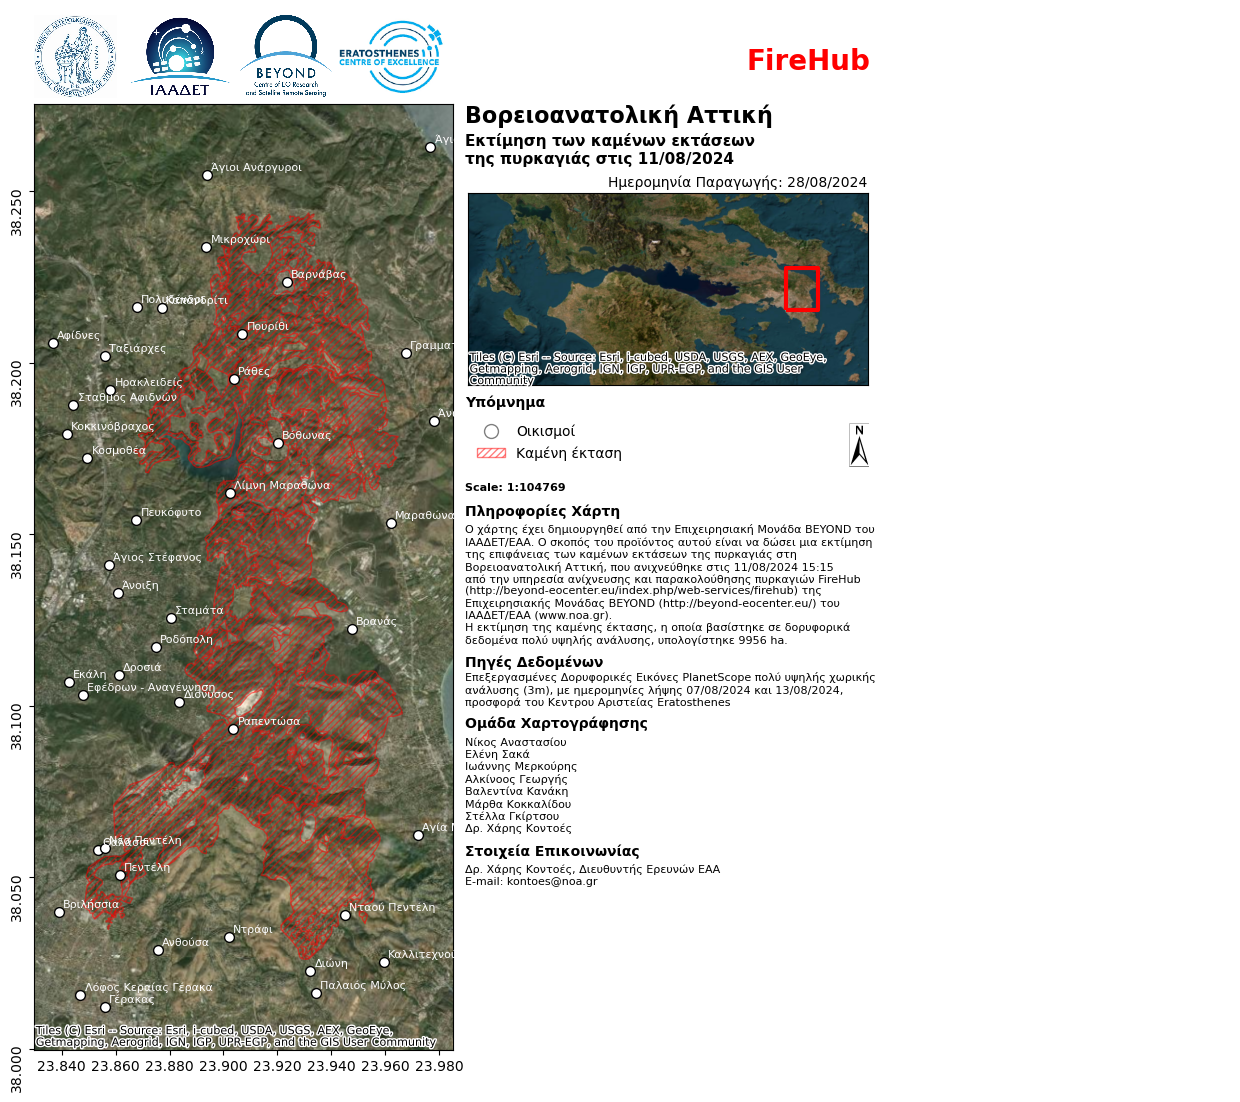

In [41]:
# Load the configuration from the JSON file
with open('cartography_config.json', 'r', encoding='utf-8') as f:
    config = json.load(f)

# Load the shapefiles
shapefile1 = gpd.read_file(config['shapefiles']['path1'])
shapefile2 = gpd.read_file(config['shapefiles']['path2'])

# Set and reproject CRS
shapefile1.crs = config['shapefiles']['epsg1']
shapefile2.crs = config['shapefiles']['epsg2']
shapefile1 = shapefile1.to_crs(epsg=4326)  # Reproject in WGS84
shapefile2 = shapefile2.to_crs(epsg=4326)  # Reproject in WGS84

# Get the bounding box of the larger shapefile
x_min, y_min, x_max, y_max = shapefile1.total_bounds
width = x_max - x_min
height = y_max - y_min

# Optionally adjust the bounding box size
expansion_factor = config['map']['expansion_factor']  #adjust this for zoom
x_min -= width * expansion_factor
x_max += width * expansion_factor
y_min -= height * expansion_factor
y_max += height * expansion_factor

# Create a polygon for the bounding box
bbox_polygon = Polygon([(x_min, y_min), (x_max, y_min), (x_max, y_max), (x_min, y_max), (x_min, y_min)])
bbox_gdf = gpd.GeoDataFrame({'geometry': [bbox_polygon]}, crs=shapefile1.crs)

# Filter shapefile2 to only include points within the bounding box of shapefile1
bounded_shapefile2 = shapefile2[shapefile2.geometry.within(bbox_polygon)]

# Create the plot
fig, ax = plt.subplots(figsize=(10, 10))
shapefile1.plot(ax=ax, edgecolor='red', facecolor='none', alpha=0.5, hatch='/////', legend=True)
bounded_shapefile2.plot(ax=ax, edgecolor='black', facecolor='white', markersize=50, alpha=1, marker='o', legend=True)

# Annotate the names of the areas
for idx, row in bounded_shapefile2.iterrows():
    plt.annotate(text=row['name'], xy=(row.geometry.centroid.x, row.geometry.centroid.y), xytext=(3, 3), textcoords='offset points', fontsize=8, color='white') # change name according to column name of the settlements

# Add the satellite basemap using contextily
ctx.add_basemap(ax, crs=shapefile1.crs.to_string(), source=ctx.providers.Esri.WorldImagery)
plt.tight_layout()

# Set the coordinates to be displayed vertically
ax.tick_params(axis='x', rotation=0)
ax.tick_params(axis='y', rotation=90)

# Set the format for the coordinates
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.3f}'))
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.3f}'))

# # Calculate the horizontal scale (in meters) based on the map extent
# scale_x = (x_max - x_min) * 111000  # Approximate value for longitude in meters at the equator
# # Calculate the vertical scale (in meters) based on the map extent
# scale_y = (y_max - y_min) * 111000  # Approximate value for latitude in meters
# # Determine the appropriate scale value based on the map extent
# scale = max(scale_x, scale_y)
# # Choose the units you want to display for the scale (e.g., meters or kilometers)
# scale_units = "μέτρο"
# # Add scale to the plot as text
# scale_text = "Κλίμακα: 1:100000"

# Calculate latitude and longitude ranges
lat_mid = (y_max + y_min) / 2  # Use the midpoint latitude for accuracy
cos_lat = np.cos(np.radians(lat_mid))  # Cosine of the latitude for longitude adjustment

# Improved horizontal and vertical scales in meters
scale_x = (x_max - x_min) * 111000 * cos_lat  # Horizontal scale adjusted for latitude
scale_y = (y_max - y_min) * 111000  # Vertical scale remains the same

# Determine the maximum scale for consistency
scale = max(scale_x, scale_y)

# Calculate the scale ratio for the map (e.g., 1:100000)
# Assuming your map is being displayed at a specific width in pixels, you can use that to get the scale ratio
real_world_width_meters = scale_x  # The real-world width represented by the map

scale_ratio = real_world_width_meters / width  # Meters per pixel

# Determine the appropriate scale text
scale_text = f"Scale: 1:{int(scale_ratio)}"

# # Add a scalebar to your plot
# scalebar = ScaleBar(1, units="m", dimension="si-length", location='lower right')  # Add units and adjust location as needed
# ax.add_artist(scalebar)

######NEW

# Create the inset map showing the area of interest (AOI)
# shapefile1 = shapefile1.to_crs(epsg=4326)
# x_min, y_min, x_max, y_max = shapefile1.total_bounds
# width = x_max - x_min
# height = y_max - y_min
expansion_factor = config['map']['expansion_factor2']  #adjust this value as needed to control the size of the AOI
x_min_ = x_min + (width * expansion_factor)
x_max_ = x_max - (width * config['map']['ysize'] * expansion_factor)
y_min_ = y_min + (height * expansion_factor)
y_max_ = y_max - (height * expansion_factor)

aoi_polygon = Polygon([(x_min-0.1, y_min-0.1), (x_max+0.1, y_min-0.1), (x_max+0.1, y_max+0.1), (x_min-0.1, y_max+0.1)]) #adjust size of red square
aoi_polygon_ = Polygon([(x_min_, y_min_), (x_max_, y_min_), (x_max_, y_max_), (x_min_, y_max_)])
aoi_gdf = gpd.GeoDataFrame(geometry=[aoi_polygon], crs=shapefile1.crs)
aoi_gdf_ = gpd.GeoDataFrame(geometry=[aoi_polygon_], crs=shapefile1.crs)

# Adjust the coordinates for the inset to be placed under the title
inset_ax = fig.add_axes([config['map']['x'], config['map']['y'], config['map']['width'], config['map']['height']])  #adjusted coordinates of smaller map
aoi_gdf_.plot(ax=inset_ax, edgecolor='red', facecolor='none', alpha=0, legend=True)
aoi_gdf.plot(ax=inset_ax, edgecolor='red', facecolor='none', alpha=1, linewidth=3, legend=True)
ctx.add_basemap(inset_ax, crs=shapefile1.crs.to_string(), source=ctx.providers.Esri.WorldImagery)
inset_ax.set_xticks([])
inset_ax.set_yticks([])
inset_ax.set_xlabel('')
inset_ax.set_ylabel('')

##########

# Add logo
#logo = plt.imread('C:\\Users\\User\\Documents\\Projects_2022\\FireHub_FireMapping_Summer\\FB TIMELINE 1200X675.jpg')
#ax.imshow(logo, extent=(0.8, 1, 0.8, 1), transform=ax.transAxes)
#small_logo = resize(logo, (200, 200)) # resize logo to 200x200 pixels

#Add title
plt.text(config['firehub']['x'], config['firehub']['y'], config['firehub']['name'], transform=ax.transAxes, rotation=0, va='top', fontweight='bold', fontsize=20, color='red') #adjust for position of FireHub

xtext = config['text_position']['x'] #adjust for position of some text on the x axis
ytext = config['text_position']['y'] #adjust for position of some text on the y axis

# Add legend
plt.text(xtext, ytext + config['ypomnima']['y'], config['ypomnima']['name'], transform=ax.transAxes, rotation=0, ha='left', va='baseline', fontweight='bold', fontsize=10) #adjust for position of "Υπόμνημα"
bbox_gdf.plot(ax=ax, edgecolor='red', facecolor='red', alpha=0, legend=True) 
plt.plot(shapefile1[config['ypomnima']['id_name1']], label=config['ypomnima']['label1']) #adjust id according to id of the burned area
plt.plot(bounded_shapefile2[config['ypomnima']['id_name2']], label=config['ypomnima']['label2']) #adust id according to id of the settlements
fire = mpatches.Patch(edgecolor='red', facecolor='none', alpha=0.5, hatch='/////', label=config['ypomnima']['label1'])
settlement = Line2D([0], [0], marker='o', color='w', label=config['ypomnima']['label2'], markerfacecolor='white', markeredgecolor='black', markersize=10, alpha=0.5)
legend = plt.legend(loc='right', title_fontproperties=fm.FontProperties(weight='bold'), bbox_to_anchor=(config['ypomnima']['xlabel'], config['ypomnima']['ylabel']), borderaxespad=0, frameon=False, handles=[settlement, fire]) #adjust for position of ypomnima values
# plt.setp(legend.get_title(), position=(-33.5, 0))  # Adjust this to move the title

# Create a location map showing the full extent of the data
#https://mohammadimranhasan.com/geospatial-data-mapping-with-python/
#a=inset_axes(shapefile1, width="30%", height='30%',loc='lower right')
#shapefile1.plot(figsize=(20,20), cmap='PuOr',ax=a)
#a.text(x=88.6, y=22.25, s='Study Area', fontsize=10)
#a.plot([88.9, 90, 90, 88.9, 88.9],[21.5, 21.5, 23, 23,21.5], lw=2)

# Get the current date
today = datetime.today().date()
today = today.strftime("%d/%m/%Y")

# Add standardised text on the side of the map
#ax.set_title(place, rotation=0, position=(1.029, 0), ha='left', va='baseline', fontweight='bold')
#adjust everything for position of text
plt.text(xtext, config['place']['y'], config['place']['name'], transform=ax.transAxes, rotation=0, ha='left', va='baseline', fontweight='bold', fontsize=16)
plt.text(xtext, config['subtitle']['y'], config['subtitle']['name'], transform=ax.transAxes, fontsize=11, va='top', fontweight='bold')
plt.text(config['production_date']['x'], config['production_date']['y'], config['production_date']['name'] + today, transform=ax.transAxes, fontsize=10, va='top')
plt.text(xtext, ytext + 0.335, scale_text, transform=ax.transAxes, fontsize=8, va='center', fontweight='bold')
plt.text(xtext, ytext + config['map_information']['y_name'], config['map_information']['name'], transform=ax.transAxes, fontsize=10, va='center', fontweight='bold')
plt.text(xtext, ytext + config['map_information']['y_text'], config['map_information']['text1'].replace('{place}', config['place']['name']) + config['map_information']['text2'].replace('{detection}', config['dates']['detection']) + config['map_information']['text3'].replace('{area}', config['area']), transform=ax.transAxes, fontsize=8, va='center')
plt.text(xtext, ytext + config['sources']['y_name'], config['sources']['name'], transform=ax.transAxes, fontsize=10, va='center', fontweight='bold')
plt.text(xtext, ytext + config['sources']['y_text'], config['sources']['product'] + config['sources']['text'].replace('{download}', config['dates']['download']), transform=ax.transAxes, fontsize=8, va='center')
# plt.text(xtext, ytext + config['publication']['y_name'], config['publication']['name'], transform=ax.transAxes, fontsize=10, va='center', fontweight='bold')
# plt.text(xtext, ytext + config['publication']['y_text'], config['publication']['text'], transform=ax.transAxes, fontsize=8, va='center')
plt.text(xtext, ytext + config['team']['y_name'], config['team']['name'], transform=ax.transAxes, fontsize=10, va='center', fontweight='bold')
plt.text(xtext, ytext + config['team']['y_text'], config['team']['text'], transform=ax.transAxes, fontsize=8, va='center')
plt.text(xtext, ytext + config['contact_details']['y_name'], config['contact_details']['name'], transform=ax.transAxes, fontsize=10, va='center', fontweight='bold')
plt.text(xtext, ytext + config['contact_details']['y_text'], config['contact_details']['text'], transform=ax.transAxes, fontsize=8, va='center')

# Add north
logo_image = plt.imread(config['logos']['north'])
logo_plot = OffsetImage(logo_image, zoom=0.7)  #adjust zoom to control logo size
ab = AnnotationBbox(logo_plot, (config['logos']['x_north'], ytext + config['logos']['y_north']), xycoords='axes fraction', frameon=False) #adjust position of north arrow
ax.add_artist(ab)

# x, y, arrow_length = 1.9, 0.6, 0.1
# ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
#             arrowprops=dict(facecolor='black', width=5, headwidth=15),
#             ha='center', va='top', fontsize=20,
#             xycoords=ax.transAxes)

# logo_path = 'logos\BEYOND_LOGO.png'  # Replace with the actual path to your logo image
# logo_image = plt.imread(logo_path)
# logo_plot = OffsetImage(logo_image, zoom=0.03)  # Adjust zoom to control logo size
# ab = AnnotationBbox(logo_plot, (x_max-0.030, y_max - height+0.001), frameon=True)
# ax.add_artist(ab)

# logo_path = 'logos\IAADET.jpeg'  # Replace with the actual path to your logo image
# logo_image = plt.imread(logo_path)
# logo_plot = OffsetImage(logo_image, zoom=0.09)  # Adjust zoom to control logo size
# ab = AnnotationBbox(logo_plot, (x_max-0.015, y_max - height+0.001), frameon=True)
# ax.add_artist(ab)

# logo_path = 'logos\AsteroskopoioLogoOuranidon.png'  # Replace with the actual path to your logo image
# logo_image = plt.imread(logo_path)
# logo_plot = OffsetImage(logo_image, zoom=0.1)  # Adjust zoom to control logo size
# ab = AnnotationBbox(logo_plot, (x_max-0.002, y_max - height+0.001), frameon=True)
# ax.add_artist(ab)

#######NEWNEW

# Add logos to the plot
logo_paths = [
    (config['logos']['first'], 0.185),
    (config['logos']['second'], 0.08),
    (config['logos']['third'], 0.123),
    (config['logos']['fourth'], 0.5)
]

# Adjusted coordinates for logos placed side by side
for i, (logo_path, zoom) in enumerate(logo_paths):
    logo_image = plt.imread(logo_path)
    logo_plot = OffsetImage(logo_image, zoom=zoom)
    ab = AnnotationBbox(logo_plot, (config['logos']['x'] + i*0.25, config['logos']['y']), xycoords='axes fraction', frameon=False) #adjust position of logos
    ax.add_artist(ab)

#########

# Save the figure
burned_map = config['images']['burned_map']
cropped_burned_map = config['images']['cropped_burned_map']
plt.savefig(burned_map, dpi=config['images']['dpi'], bbox_inches='tight')

# Show the plot
plt.show()

# Close the figure to release memory
plt.close(fig)

# Load the image
image = Image.open(burned_map)

# Get the dimensions of the original image
width, height = image.size

# Define the crop area
left = 0       # Keep the left side as is
upper = 0      # Keep the top side as is
right = width - config['images']['crop_factor']  # Crop 100 pixels from the right
lower = height  # Keep the bottom side as is

# Crop the image
cropped_image = image.crop((left, upper, right, lower))

# Save the cropped image
cropped_image.save(cropped_burned_map)

# Delete the original image
os.remove(burned_map)

# Optionally, show the cropped image
cropped_image.show()